<a href="https://colab.research.google.com/github/pdrzxzz/breast_cancer_wisconsin_diagnostic/blob/main/breast_cancer_wisconsin_diagnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
# Basic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
from sklearn.preprocessing import StandardScaler

# Model adjustments
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [204]:
# List available fonts
# import matplotlib.font_manager
# for f in matplotlib.font_manager.fontManager.ttflist:
#     print(f.name)

In [203]:
# Color of the plots
CMAP = "Greens"

# Change font.family globally
plt.rcParams["font.family"] = "Liberation Serif"

In [2]:
!pip install ucimlrepo

In [3]:
# Fetch dataset (https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
from ucimlrepo import fetch_ucirepo
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Split data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

In [4]:
# Convert y from dataframe to 1D array (easier to models use)
y = y.values.ravel()

In [20]:
def print_proportion_of_values(series):
  for c in series.unique():
    print(f"{int(series.value_counts().loc[c])/len(series)*100:.2f}% {c}")

In [21]:
# Proportion of target data
print_proportion_of_values(pd.Series(y))

37.26% M
62.74% B


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Check stratify
print("Train: ")
print_proportion_of_values(pd.Series(y_train))
print("Test: ")
print_proportion_of_values(pd.Series(y_test))

Train: 
62.81% B
37.19% M
Test: 
62.57% B
37.43% M


In [25]:
pd.DataFrame(X_train_scaled).head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.350629,0.038573,-0.375394,-0.407176,-0.343801,-0.451566,-0.856479,-0.688458,0.198484,0.113622,...,-0.373555,-0.224975,-0.356316,-0.444864,-0.465289,-0.546261,-0.933826,-0.737049,0.687716,-0.356293
1,1.974650,1.632742,2.074151,1.850200,1.273349,3.342095,1.933915,2.504740,2.152907,1.651250,...,2.188408,1.244879,2.069841,2.170321,0.759682,3.196602,1.889250,2.639275,1.974323,2.439058
2,0.243420,0.088462,0.148139,0.102409,-0.852271,-0.921388,-0.838339,-0.725923,-1.067864,-1.467895,...,-0.053047,0.007618,-0.142805,-0.167265,-1.212655,-0.957963,-0.904839,-0.830977,-0.405489,-1.259785


In [223]:
def personalized_confusion_matrix(model_name, y_true, y_pred, ax):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()

    # Matrix labels
    labels = np.array([['TN', 'FP'], ['FN', 'TP']])
    percentages = cm / total * 100
    annot = np.empty_like(cm).astype(str)

    # Create annotation with label, absolute count, and percentage
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{labels[i, j]}\n{cm[i, j]}\n{percentages[i, j]:.1f}%'

    # Create DataFrame for the heatmap
    df_cm = pd.DataFrame(cm, index=['Actual: 0', 'Actual: 1'], columns=['Predicted: 0', 'Predicted: 1'])

    # Plot with seaborn
    sns.heatmap(df_cm, annot=annot, fmt="", vmin=-300, vmax=130, cmap=CMAP, cbar=False, ax=ax)
    # ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()

In [213]:
def personalized_classification_report(model_name, y_true, y_pred, ax):
  clf_report = classification_report(y_true, y_pred, output_dict=True)
  clf_report.pop("accuracy", None)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, vmin=0.7, vmax=1, cmap=CMAP, annot=True, cbar=False, ax=ax)
  ax.set_title(f'{model_name}', weight='bold')
  accuracy = accuracy_score(y_true, y_pred)
  ax.text(0.5, -0.3, f'Accuracy: {accuracy:.2f}', ha='center', va='center', fontsize=10, transform=ax.transAxes)

In [221]:
def evaluate_classifier(model, model_name, X_train, X_test, y_train, y_test, classification_ax=None, confusion_matrix_ax=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    classification_ax and personalized_classification_report(model_name, y_test, y_pred, ax=classification_ax)
    confusion_matrix_ax and personalized_confusion_matrix(model_name, y_test, y_pred, ax=confusion_matrix_ax)

def compare_classifiers(models, models_names, X_train, X_test, y_train, y_test):
  assert len(models) == len(models_names)
  assert len(models) <= 4
  fig, axs = plt.subplots(2, 4, figsize=(len(models)*4, len(models)*1.5))
  for ax, classifier, classifier_name in zip(axs.flat[:len(models)+1], models, models_names):
    evaluate_classifier(classifier, classifier_name, X_train_scaled, X_test_scaled, y_train, y_test, classification_ax=ax)
  for ax, classifier, classifier_name in zip(axs.flat[len(models):len(models)*2], models, models_names):
    evaluate_classifier(classifier, classifier_name, X_train_scaled, X_test_scaled, y_train, y_test, confusion_matrix_ax=ax)

  fig.suptitle("Classifiers Comparision", size="xx-large", weight="bold")
  fig.text(
         x=0.5, y=-0.01,
         s="TN: True Negative | FP: False Positive | FN: False Negative | TP: True Positive",
         ha='center', fontsize="small")
  plt.tight_layout()

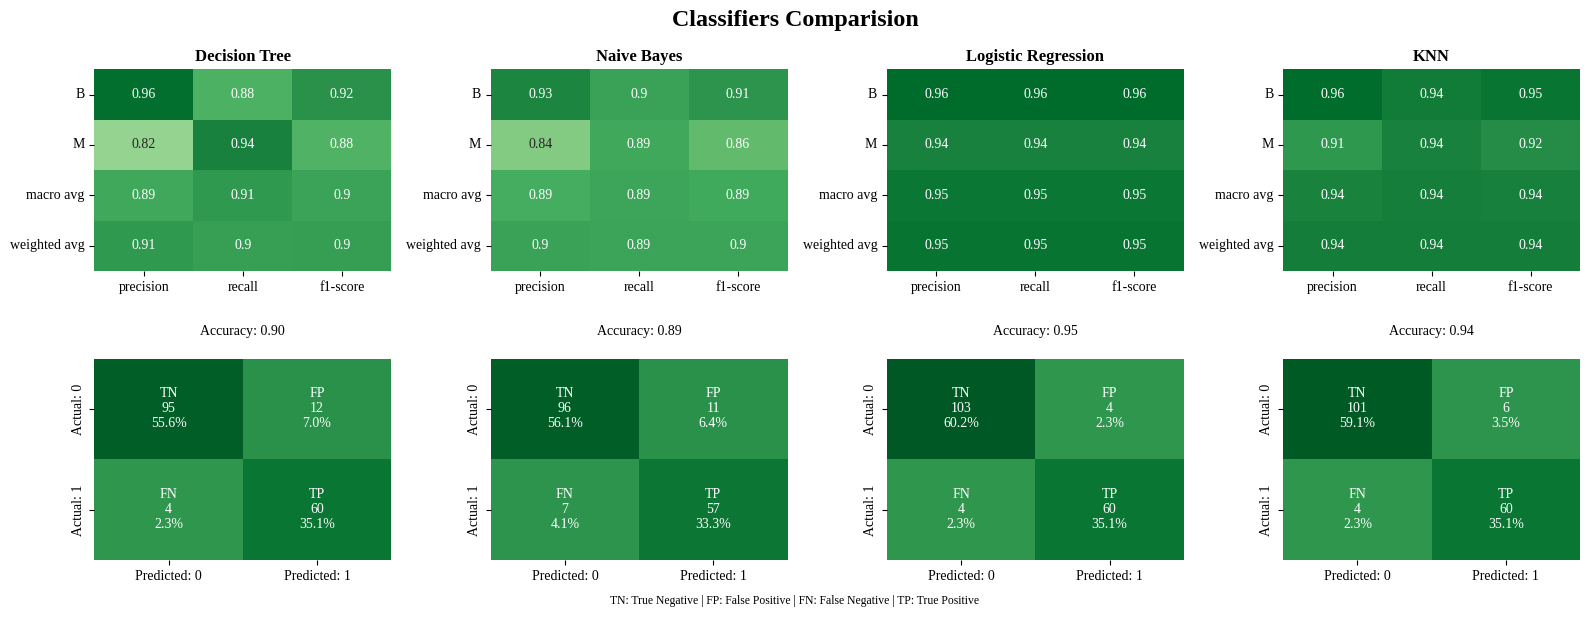

In [224]:
compare_classifiers(
    [DecisionTreeClassifier(), GaussianNB(), LogisticRegression(max_iter=1000),KNeighborsClassifier()],
    ["Decision Tree", "Naive Bayes", "Logistic Regression", "KNN"],
    X_train_scaled, X_test_scaled, y_train, y_test
    )

In [30]:
# Hyperparameter optimization
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

